## Import libraries

In [12]:
from pymanopt.manifolds import SymmetricPositiveDefinite
import math
import numpy as np
from scipy.linalg import sqrtm, norm, expm, logm, eigh
import numpy.linalg
# plotting/visualization
import matplotlib.pyplot as plt

### Utils

In [6]:
def enforce_spd(S, eps=1e-15):
    """Project a symmetric matrix to SPD by eigenvalue flooring."""
    S = 0.5 * (S + S.T)
    w, V = np.linalg.eigh(S)                 # symmetric eigendecomp is most stable
    # scale-aware floor: keeps conditioning sane without over-regularizing
    # floor = max(eps, 1e-12 * max(1.0, np.max(np.abs(w))))
    w_clipped = np.clip(w, eps, None)
    return (V * w_clipped) @ V.T

### Task 1: Optimization of |\log \det X - target|^p

In [ ]:
def entropy_gds(spd_mfd, num_iter, step_size=1, init_x = None, adaptive = True, A_order = 0, target_value = 1, zeta = None, p = 2):
  """
  Conduct GD for f(X) = |\log \det X - target|^p
  Reference: https://github.com/jungbinkim1/RNAG?tab=readme-ov-file
  """
  # create a list to save the result
  gd_f_list = []

  # initialize
  if init_x is None:
    gd_x_k = spd_mfd.random_point()
  else:
    gd_x_k = init_x

  # save the initial result
  # current_gd_f = -np.linalg.slogdet(gd_x_k)[1]
  current_gd_f = (np.linalg.slogdet(gd_x_k)[1] - target_value)**p
  gd_f_list.append(current_gd_f)

  # create a step-size list
  stepsize_list = []

  # For adaptive methods
  list_len = num_iter + 2
  A = [None] * (list_len)
  B = [None] * (list_len)
  tilde_B = [None] * (list_len)
  for i in range(list_len):
    if A_order == 1:
      A[i] = (i+5)/2
      if zeta is None:
        tilde_B[i] = (i+1)/2
        B[i] = 0.499 * (i+1)/2
      else:
        B[i] = (i+1)/2
        tilde_B[i] = B[i] + zeta
    elif A_order == 0.5:
      a = 2
      A[i] = 2 * np.sqrt(i+a) + 2
      if zeta is None:
        B[i] = 0.499 * (2 * np.sqrt(i+a-2) - 2 + (5 / (1 + 2 * np.sqrt(i+a-2))))
        tilde_B[i] = 2 * np.sqrt(i+a-2) - 2 + (5 / (1 + 2 * np.sqrt(i+a-2)))
      else:
        B[i] = (2 * np.sqrt(i+a-2) - 2 + (5 / (1 + 2 * np.sqrt(i+a-2))))
        tilde_B[i] = B[i] + zeta
    elif A_order == 0:
      A[i] = 3
      B[i] = 5/4
      tilde_B[i] = 5/4 + 1
    else:
      a = 2
      A[i] = 2 * np.power(i+a, A_order) + 2
      if zeta is None:
        tilde_B[i] = A[i] - 2
        B[i] = 0.499 * tilde_B[i]
      else:
        B[i] = A[i] - 2
        tilde_B[i] = B[i] + zeta
  s0 = step_size
  s_t1 = s0
  L_e = L
  theta_t = 0
  s_prev = s_t1

  # run the gradient methods
  for curr_iter in range(2, num_iter + 1):
    # calculate gradient
    # gd_grad = spd_mfd.euclidean_to_riemannian_gradient(gd_x_k, -gd_x_k)
    gd_grad = spd_mfd.euclidean_to_riemannian_gradient(
        gd_x_k, (p * ((np.linalg.slogdet(gd_x_k)[1] - target_value)) ** (p-1)) * np.linalg.inv(gd_x_k)
        )
    # gd_grad = ((np.linalg.slogdet(gd_x_k)[1] - target_value)) * gd_x_k
    # compute adaptive stepsize
    if adaptive:
      t= curr_iter
      s_prev = s_t1
      if t == 0:
        s_t1 = min(min(1/A[0], A[0]/tilde_B[1]) * s_prev, ( A[0]**2 + B[0] * (tilde_B[1]) ) * 1/L_e)
        # s_t1 = min( 1/A[0] * s_prev, A[0] * B[0] / ( A[0]**2 + B[0] * (tilde_B[1]) ) * 1/L_e)
      elif t >= 1:
        t = t+1
        r_s = min((A[t-2]+1)/A[t-1], A[t-1]/tilde_B[t])
        if L_e > 0:
          if s_prev >= (1/L_e):
            r_l = A[t-1] * B[t-1] / ( A[t-1]**2 + B[t-1] * tilde_B[t] )
          else:
            r_l = A[t-1]/(tilde_B[t])
          s_t1 = min(r_s * s_prev, r_l * 1/L_e)
        else:
          s_t1 = r_s * s_prev

      # adaptive GD update
      stepsize_list.append(s_t1)
      # f_old = -np.linalg.slogdet(gd_x_k)[1]
      f_old = (np.linalg.slogdet(gd_x_k)[1] - target_value)**p
      gd_x_next = spd_mfd.exp(gd_x_k, -s_t1 * gd_grad)
      gd_x_next = enforce_spd(gd_x_next)
      # f_new = -np.linalg.slogdet(gd_x_next)[1]
      f_new = (np.linalg.slogdet(gd_x_next)[1] - target_value)**p

      # compute adaptive stepsize
      # gd_grad_next = spd_mfd.euclidean_to_riemannian_gradient(gd_x_next, -0.5 * gd_x_next)
      gd_grad_next = spd_mfd.euclidean_to_riemannian_gradient(
          gd_x_next, (p * ((np.linalg.slogdet(gd_x_next)[1] - target_value)) ** (p-1)) * np.linalg.inv(gd_x_next)
      )
      # gd_grad_next = ((np.linalg.slogdet(gd_x_next)[1] - target_value)) * gd_x_next
      gd_grad_next_on_old = spd_mfd.transport(gd_x_next, gd_x_k, gd_grad_next)
      diff = gd_grad_next_on_old - gd_grad
      numerator = spd_mfd.norm(gd_x_k, diff)
      if numerator == 0:
        L_e = 0
      else:
        denominator = -2*(f_new - f_old + s_t1 * spd_mfd.inner_product(gd_x_k, gd_grad, gd_grad_next_on_old))
        L_e = np.exp(np.log(numerator) - np.log(denominator))
        if L_e < 0 or (math.isnan(L_e)):
          L_e = 0
      # print(L_e)
      gd_x_k = gd_x_next
    else:
      stepsize_list.append(step_size)
      gd_x_k = spd_mfd.exp(gd_x_k, -step_size * gd_grad)
      gd_x_k = enforce_spd(gd_x_k)
    # save the result
    current_gd_f = (np.linalg.slogdet(gd_x_k)[1] - target_value) ** p
    gd_f_list.append(current_gd_f)

  # save the last result
  gd_x_last = gd_x_k

  # return the result
  return gd_f_list, gd_x_last, stepsize_list

In [9]:
# Reference: https://github.com/jungbinkim1/RNAG?tab=readme-ov-file
np.random.seed(123)
d = 50 #problem dimension
spd_mfd = SymmetricPositiveDefinite(n = d)
init_value = spd_mfd.random_point()
gd_x_last_j = init_value
target_value = 1
p = 4

In [10]:
L = 20000
small_L = 0.5 * L
large_L = 2 * L
num_subiter = 1000
A_order_experi = 0.1
gd_f_list_final = []
silver_gd_f_list_final = []
gd_f_list, gd_x_last, stepsize_gd = entropy_gds(spd_mfd, num_subiter, step_size=1/L, init_x = init_value, adaptive=False, p = p)
print("GD Done")
gd_f_list_small, gd_x_last_small, stepsize_gd_small = entropy_gds(
    spd_mfd, num_subiter, step_size=1/small_L, init_x = init_value, adaptive=False, p = p
    )
print("GD Done (small_L)")
gd_f_list_large, gd_x_last_large, stepsize_gd_large = entropy_gds(
    spd_mfd, num_subiter, step_size=1/large_L, init_x = init_value, adaptive=False, p = p
    )
print("GD Done (large L)")
adap_gd_f_list_a01, adap_gd_x_last_a01, stepsize_a0 = entropy_gds(spd_mfd, num_subiter,
                                                                  step_size=1e-02/L, init_x = init_value, adaptive=True,
                                                                  A_order = A_order_experi, zeta = 1, p = p)
print(f"AdaGDO({A_order_experi}) Done")

/opt/homebrew/anaconda3/envs/radagd/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:322: RuntimeWarning: overflow encountered in exp
  eA[ind] = np.diag(np.exp(np.diag(aw)))
/opt/homebrew/anaconda3/envs/radagd/lib/python3.10/site-packages/pymanopt/manifolds/positive_definite.py:100: RuntimeWarning: invalid value encountered in matmul
  return point @ multiexpm(p_inv_tv, symmetric=False)


GD Done
GD Done (small_L)
GD Done (large L)


/var/folders/zj/m2bc_5qd3gq_tddbny9n_wqr0000gn/T/ipykernel_44923/3287482058.py:114: RuntimeWarning: invalid value encountered in log
  L_e = np.exp(np.log(numerator) - np.log(denominator))


AdaGDO(0.1) Done


### Plotting

Stepsize

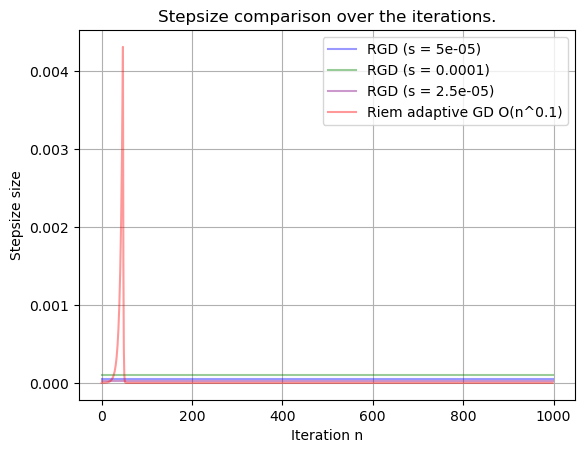

In [13]:
iterations = list(range((num_subiter-1)))  # Create the x-axis (iteration numbers)
colors = ['blue', 'green', "purple","red"]
labels = [f"RGD (s = {1/L})", f"RGD (s = {1/small_L})", f"RGD (s = {1/large_L})",
          f"Riem adaptive GD O(n^{A_order_experi})"] # Labels for the legend

plt.plot(iterations, stepsize_gd, color=colors[0], label=labels[0], linestyle = '-', alpha = 0.4)
plt.plot(iterations, stepsize_gd_small, color=colors[1], label=labels[1], linestyle = '-', alpha = 0.4)
plt.plot(iterations, stepsize_gd_large, color=colors[2], label=labels[2], linestyle = '-', alpha = 0.4)
plt.plot(iterations, stepsize_a0, color=colors[3], label=labels[3],linestyle = '-', alpha = 0.4)

# Add labels and title
plt.xlabel("Iteration n")
plt.ylabel("Stepsize size")
plt.title("Stepsize comparison over the iterations." )
# plt.xscale('log',base=10)
# plt.ylim(top = stepsize_a1[100])

# Add a legend
plt.legend()

# Show the plot
plt.grid(True)
plt.show()

Function value

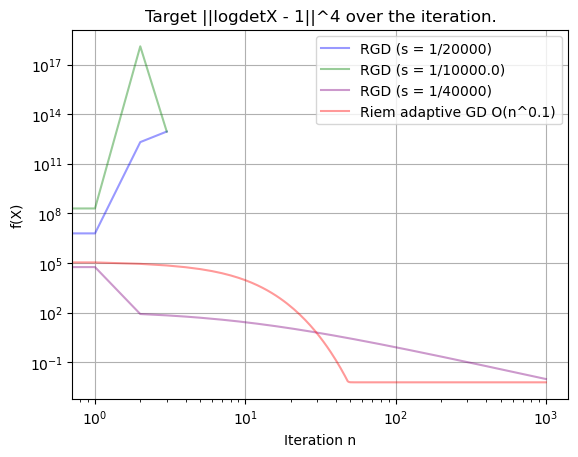

In [14]:
iterations = list(range((num_subiter)))  # Create the x-axis (iteration numbers)

colors = ['blue', 'green', "purple","red"]
labels = [f"RGD (s = 1/{L})", f"RGD (s = 1/{small_L})", f"RGD (s = 1/{large_L})",
          f"Riem adaptive GD O(n^{A_order_experi})"] # Labels for the legend

# min_value = np.minimum(adap_gd_kl_list_a01[-1], adap_gd_kl_list_mal[-1])

plt.plot(iterations, gd_f_list, color=colors[0], label=labels[0], linestyle = '-', alpha = 0.4)
plt.plot(iterations, gd_f_list_small, color=colors[1], label=labels[1], linestyle = '-', alpha = 0.4)
plt.plot(iterations, gd_f_list_large, color=colors[2], label=labels[2], linestyle = '-', alpha = 0.4)
plt.plot(iterations, adap_gd_f_list_a01, color=colors[3], label=labels[3],linestyle = '-', alpha = 0.4)

# Add labels and title
plt.xlabel("Iteration n")
plt.ylabel("f(X)")
plt.title("Target ||logdetX - 1||^4 over the iteration." )
plt.xscale('log',base=10)

plt.yscale('log',base=10)
# plt.ylim(top = gd_v_list_final[0])

# Add a legend
plt.legend()

# Show the plot
plt.grid(True)
plt.show()

### Task 2: Linear + entropy penalty

In [16]:
def entropy_linear_gds(spd_mfd, num_iter, C, step_size=1, init_x = None, adaptive = True, A_order = 0, zeta = None):
  """
  Conduct GD for f(X) = tr(XC) - \log \det X
  """
  # create a list to save the result
  gd_f_list = []

  # initialize
  if init_x is None:
    gd_x_k = spd_mfd.random_point()
  else:
    gd_x_k = init_x

  # save the initial result
  current_gd_f = np.trace(gd_x_k @ C) - np.linalg.slogdet(gd_x_k)[1]
  gd_f_list.append(current_gd_f)

  # create a step-size list
  stepsize_list = []

  # For adaptive methods
  list_len = num_iter + 2
  A = [None] * (list_len)
  B = [None] * (list_len)
  tilde_B = [None] * (list_len)
  for i in range(list_len):
    if A_order == 1:
      A[i] = (i+5)/2
      if zeta is None:
        tilde_B[i] = (i+1)/2
        B[i] = 0.499 * (i+1)/2
      else:
        B[i] = (i+1)/2
        tilde_B[i] = B[i] + zeta
    elif A_order == 0.5:
      a = 2
      A[i] = 2 * np.sqrt(i+a) + 2
      if zeta is None:
        B[i] = 0.499 * (2 * np.sqrt(i+a-2) - 2 + (5 / (1 + 2 * np.sqrt(i+a-2))))
        tilde_B[i] = 2 * np.sqrt(i+a-2) - 2 + (5 / (1 + 2 * np.sqrt(i+a-2)))
      else:
        B[i] = (2 * np.sqrt(i+a-2) - 2 + (5 / (1 + 2 * np.sqrt(i+a-2))))
        tilde_B[i] = B[i] + zeta
    elif A_order == 0:
      A[i] = 3
      B[i] = 5/4
      tilde_B[i] = 5/4 + 1
    else:
      a = 2
      A[i] = 2 * np.power(i+a, A_order) + 2
      if zeta is None:
        tilde_B[i] = A[i] - 2
        B[i] = 0.499 * tilde_B[i]
      else:
        B[i] = A[i] - 2
        tilde_B[i] = B[i] + zeta
  s0 = step_size
  s_t1 = s0
  L_e = L
  theta_t = 0
  s_prev = s_t1

  # run the gradient methods
  for curr_iter in range(2, num_iter + 1):
    # calculate gradient
    gd_grad = spd_mfd.euclidean_to_riemannian_gradient(gd_x_k, C - np.linalg.inv(gd_x_k))
    # compute adaptive stepsize
    if adaptive:
      t= curr_iter
      s_prev = s_t1
      if t == 0:
        s_t1 = min(min(1/A[0], A[0]/tilde_B[1]) * s_prev, ( A[0]**2 + B[0] * (tilde_B[1]) ) * 1/L_e)
        # s_t1 = min( 1/A[0] * s_prev, A[0] * B[0] / ( A[0]**2 + B[0] * (tilde_B[1]) ) * 1/L_e)
      elif t >= 1:
        t = t+1
        r_s = min((A[t-2]+1)/A[t-1], A[t-1]/tilde_B[t])
        if L_e > 0:
          if s_prev >= (1/L_e):
            r_l = A[t-1] * B[t-1] / ( A[t-1]**2 + B[t-1] * tilde_B[t] )
          else:
            r_l = A[t-1]/(tilde_B[t])
          s_t1 = min( r_s * s_prev, r_l * 1/L_e)
        else:
          s_t1 = r_s * s_prev

      # adaptive GD update
      stepsize_list.append(s_t1)
      # f_old = -np.linalg.slogdet(gd_x_k)[1]
      gd_grad = spd_mfd.euclidean_to_riemannian_gradient(gd_x_k, C - np.linalg.inv(gd_x_k))
      f_old = np.trace(gd_x_k @ C) - np.linalg.slogdet(gd_x_k)[1]
      gd_x_next = spd_mfd.exp(gd_x_k, -s_t1 * gd_grad)
      # f_new = -np.linalg.slogdet(gd_x_next)[1]
      f_new = np.trace(gd_x_next @ C) - np.linalg.slogdet(gd_x_next)[1]

      # compute adaptive stepsize
      gd_grad_next = spd_mfd.euclidean_to_riemannian_gradient(gd_x_next, C - np.linalg.inv(gd_x_next))
      gd_grad_next_on_old = spd_mfd.transport(gd_x_next, gd_x_k, gd_grad_next)
      diff = gd_grad_next_on_old - gd_grad
      numerator = spd_mfd.norm(gd_x_k, diff)
      if numerator == 0:
        L_e = 0
      else:
        denominator = -2*(f_new - f_old + s_t1 * spd_mfd.inner_product(gd_x_k, gd_grad, gd_grad_next_on_old))
        L_e = np.exp(np.log(numerator) - np.log(denominator))
        if L_e < 0 or (math.isnan(L_e)):
          L_e = 0
      # print(L_e)
      gd_x_k = gd_x_next
    else:
      stepsize_list.append(step_size)
      gd_x_k = spd_mfd.exp(gd_x_k, -step_size * gd_grad)
    # save the result
    current_gd_f = np.trace(gd_x_k @ C) - np.linalg.slogdet(gd_x_k)[1]
    gd_f_list.append(current_gd_f)

  # save the last result
  gd_x_last = gd_x_k

  # return the result
  return gd_f_list, gd_x_last, stepsize_list

### Simulations

Data generation

In [15]:
np.random.seed(123)
d = 50 #problem dimension
spd_mfd = SymmetricPositiveDefinite(n = d)
C = spd_mfd.random_point()
init_value = spd_mfd.random_point()
gd_x_last_j = init_value

Experiments

In [17]:
L = 0.5
small_L = 0.5 * L
large_L = 2 * L
num_subiter = 100
A_order_experi = 0.1
gd_f_list_final = []
silver_gd_f_list_final = []
gd_f_list, gd_x_last, stepsize_gd = entropy_linear_gds(spd_mfd, num_subiter, C = C, step_size=1/L, init_x = init_value, adaptive=False)
print("GD Done")
gd_f_list_small, gd_x_last_small, stepsize_gd_small = entropy_linear_gds(
    spd_mfd, num_subiter, C = C, step_size=1/small_L, init_x = init_value, adaptive=False
    )
print("GD Done (small_L)")
gd_f_list_large, gd_x_last_large, stepsize_gd_large = entropy_linear_gds(
    spd_mfd, num_subiter, C = C, step_size=1/large_L, init_x = init_value, adaptive=False
    )
print("GD Done (large L)")
adap_gd_f_list_a01, adap_gd_x_last_a01, stepsize_a0 = entropy_linear_gds(spd_mfd, num_subiter, C = C,
                                                                  step_size=1e-02/L, init_x = init_value, adaptive=True,
                                                                  A_order = A_order_experi, zeta = None)
print(f"AdaGDO({A_order_experi}) Done")

GD Done
GD Done (small_L)
GD Done (large L)


/opt/homebrew/anaconda3/envs/radagd/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:373: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
/opt/homebrew/anaconda3/envs/radagd/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:373: RuntimeWarning: invalid value encountered in matmul
  eAw = eAw @ eAw
/var/folders/zj/m2bc_5qd3gq_tddbny9n_wqr0000gn/T/ipykernel_44923/819881235.py:104: RuntimeWarning: invalid value encountered in log
  L_e = np.exp(np.log(numerator) - np.log(denominator))


AdaGDO(0.1) Done


Stepsize plot

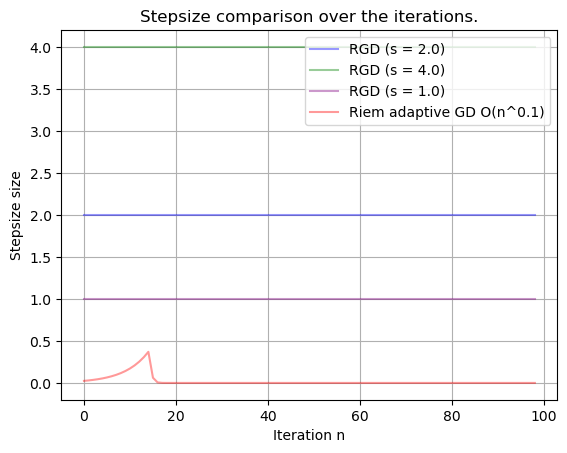

In [18]:
iterations = list(range((num_subiter-1)))  # Create the x-axis (iteration numbers)
colors = ['blue', 'green', "purple","red"]
labels = [f"RGD (s = {1/L})", f"RGD (s = {1/small_L})", f"RGD (s = {1/large_L})",
          f"Riem adaptive GD O(n^{A_order_experi})"] # Labels for the legend

plt.plot(iterations, stepsize_gd, color=colors[0], label=labels[0], linestyle = '-', alpha = 0.4)
plt.plot(iterations, stepsize_gd_small, color=colors[1], label=labels[1], linestyle = '-', alpha = 0.4)
plt.plot(iterations, stepsize_gd_large, color=colors[2], label=labels[2], linestyle = '-', alpha = 0.4)
plt.plot(iterations, stepsize_a0, color=colors[3], label=labels[3],linestyle = '-', alpha = 0.4)

# Add labels and title
plt.xlabel("Iteration n")
plt.ylabel("Stepsize size")
plt.title("Stepsize comparison over the iterations." )
# plt.xscale('log',base=10)
# plt.ylim(top = stepsize_a1[100])

# Add a legend
plt.legend()

# Show the plot
plt.grid(True)
plt.show()

Function value

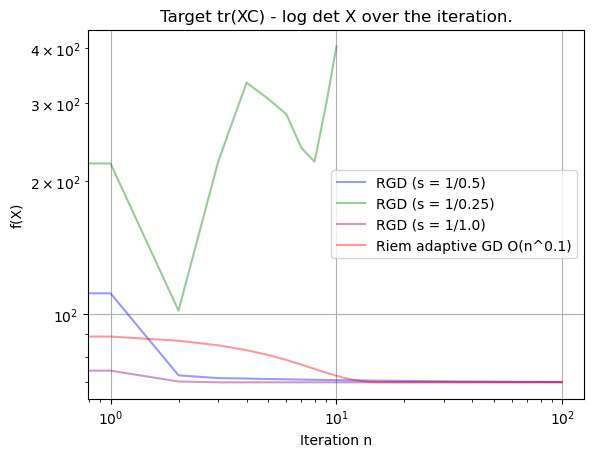

In [19]:
iterations = list(range((num_subiter)))  # Create the x-axis (iteration numbers)

colors = ['blue', 'green', "purple","red"]
labels = [f"RGD (s = 1/{L})", f"RGD (s = 1/{small_L})", f"RGD (s = 1/{large_L})",
          f"Riem adaptive GD O(n^{A_order_experi})"] # Labels for the legend

# min_value = np.minimum(adap_gd_kl_list_a01[-1], adap_gd_kl_list_mal[-1])

plt.plot(iterations, gd_f_list, color=colors[0], label=labels[0], linestyle = '-', alpha = 0.4)
plt.plot(iterations, gd_f_list_small, color=colors[1], label=labels[1], linestyle = '-', alpha = 0.4)
plt.plot(iterations, gd_f_list_large, color=colors[2], label=labels[2], linestyle = '-', alpha = 0.4)
plt.plot(iterations, adap_gd_f_list_a01, color=colors[3], label=labels[3],linestyle = '-', alpha = 0.4)

# Add labels and title
plt.xlabel("Iteration n")
plt.ylabel("f(X)")
plt.title("Target tr(XC) - log det X over the iteration." )
plt.xscale('log',base=10)

plt.yscale('log',base=10)
# plt.ylim(top = gd_v_list_final[0])

# Add a legend
plt.legend()

# Show the plot
plt.grid(True)
plt.show()

# Additional experiments in Appendix

## Gaussian mixture